<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                2311 non-null   int64  
 1   Trimester           2311 non-null   int64  
 2   District            2311 non-null   object 
 3   Neighbourhood       2311 non-null   object 
 4   Price (euro/month)  2311 non-null   float64
 5   Price (euro/m2)     2311 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 108.5+ KB
None
              Year    Trimester  Price (euro/month)  Price (euro/m2)
count  2311.000000  2311.000000         2311.000000      2311.000000
mean   2017.745565     2.440502          820.780658              inf
std       2.463095     1.116498          255.450568              NaN
min    2014.000000     1.000000          142.340000        -1.000000
25%    2016.000000     1.000000          653.860000        10.556407
50%    2018.000000 

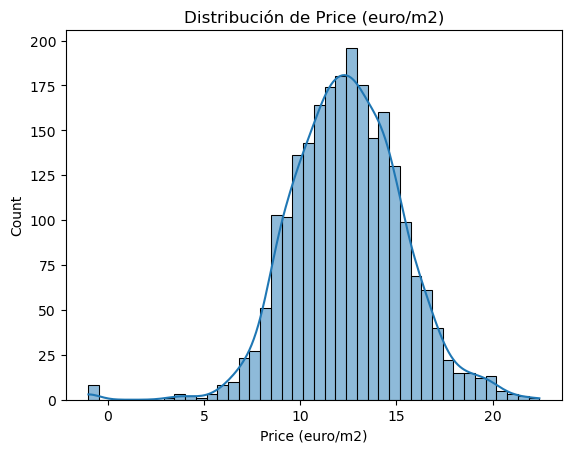

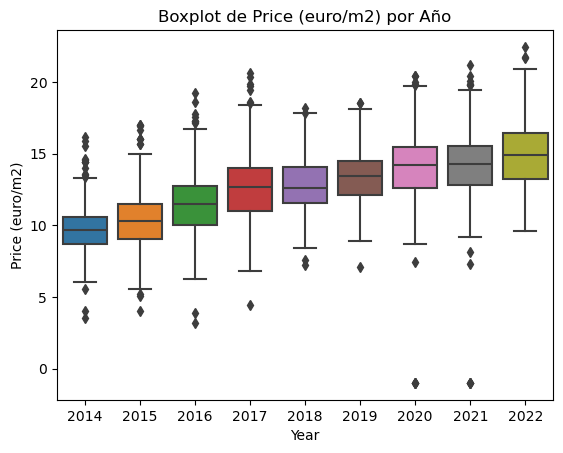

In [39]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
data = pd.read_csv("./data_reconstruido_2014_2022.csv")

# Análisis Exploratorio de Datos (EDA)
print(data.info())
print(data.describe())

sns.histplot(data['Price (euro/m2)'], kde=True)
plt.title('Distribución de Price (euro/m2)')
plt.show()

sns.boxplot(x='Year', y='Price (euro/m2)', data=data)
plt.title('Boxplot de Price (euro/m2) por Año')
plt.show()


Paso 2: Identificar y Corregir Outliers utilizando K-means Clustering

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Asumiendo que tienes un DataFrame 'data'
# Filtrar solo las columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Escalar los datos
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(numeric_data)

# Calcular SSE para diferentes valores de k
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse[k] = kmeans.inertia_

# Graficar SSE vs. k para encontrar el número óptimo de clústeres
plt.figure(figsize=(8, 6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Número de clústeres")
plt.ylabel("SSE")
plt.title("Método del Codo para encontrar el número óptimo de clústeres")
plt.show()

# Basado en el gráfico del codo, seleccionamos el número óptimo de clústeres
optimal_k = 4  # Ajusta este valor según tu gráfico

# Aplicar K-means clustering con el número óptimo de clústeres
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Añadir la información de clúster al DataFrame original
data['Cluster'] = clusters

# Calcular la distancia de cada punto a su centroide
data['Distance_to_Centroid'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[clusters], axis=1)

# Definir el umbral para identificar outliers (percentil 95)
threshold = data['Distance_to_Centroid'].quantile(0.95)

# Marcar los outliers
data['Is_Outlier'] = data['Distance_to_Centroid'] > threshold

# Eliminar outliers
data_clean = data[~data['Is_Outlier']]




ValueError: Input X contains infinity or a value too large for dtype('float64').

Paso 3: Aplicar Transformación Logarítmica

In [ ]:
# Aplicar transformación logarítmica
data_clean['log_Price (euro/m2)'] = np.log1p(data_clean['Price (euro/m2)'])
data_clean['log_Price (euro/month)'] = np.log1p(data_clean['Price (euro/month)'])


/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_98346/3522653974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['log_Price (euro/m2)'] = np.log1p(data_clean['Price (euro/m2)'])
/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_98346/3522653974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['log_Price (euro/month)'] = np.log1p(data_clean['Price (euro/month)'])


Paso 4: Codificación de Variables Categóricas

In [ ]:
# Codificación de variables categóricas
data_encoded = pd.get_dummies(data_clean, columns=['District', 'Neighbourhood'])

# División en características (X) y variables objetivo transformadas (y)
X = data_encoded.drop(['Price (euro/m2)', 'log_Price (euro/m2)', 'Price (euro/month)', 'log_Price (euro/month)'], axis=1)
y_log_price_m2 = data_encoded['log_Price (euro/m2)']
y_log_price_month = data_encoded['log_Price (euro/month)']


Paso 5: Escalado de los Datos

In [ ]:
# Escalado de los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


Paso 6: Entrenamiento y Evaluación del Modelo Ridge para Price (euro/m2)

In [ ]:
# División en conjuntos de entrenamiento y prueba para Price (euro/m2)
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_scaled, y_log_price_m2, test_size=0.2, random_state=42)

# Entrenar y evaluar el modelo Ridge para Price (euro/m2)
ridge_model_m2 = Ridge(alpha=1.0)
ridge_model_m2.fit(X_train_m2, y_train_m2)
y_pred_log_m2 = ridge_model_m2.predict(X_test_m2)
y_pred_m2 = np.expm1(y_pred_log_m2)  # Deshacer la transformación logarítmica
y_test_exp_m2 = np.expm1(y_test_m2)

mae_m2 = mean_absolute_error(y_test_exp_m2, y_pred_m2)
mse_m2 = mean_squared_error(y_test_exp_m2, y_pred_m2)
rmse_m2 = np.sqrt(mse_m2)
r2_m2 = r2_score(y_test_exp_m2, y_pred_m2)

print(f'Price (euro/m2) - MAE: {mae_m2}, MSE: {mse_m2}, RMSE: {rmse_m2}, R²: {r2_m2}')

# Validación cruzada con KFold para Price (euro/m2)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_m2 = cross_val_score(ridge_model_m2, X_train_m2, y_train_m2, cv=kf, scoring='r2', n_jobs=-1)
print(f'Price (euro/m2) - Validación cruzada R²: {scores_m2.mean()}, {scores_m2.std()}')


Price (euro/m2) - MAE: 0.7591687582382324, MSE: 0.9169230094066858, RMSE: 0.9575609690284405, R²: 0.8243476537210949


Price (euro/m2) - Validación cruzada R²: 0.8265328126272772, 0.010845863118136182


Paso 7: Entrenamiento y Evaluación del Modelo Ridge para Price (euro/month)

In [ ]:
# División en conjuntos de entrenamiento y prueba para Price (euro/month)
X_train_month, X_test_month, y_train_month, y_test_month = train_test_split(X_scaled, y_log_price_month, test_size=0.2, random_state=42)

# Entrenar y evaluar el modelo Ridge para Price (euro/month)
ridge_model_month = Ridge(alpha=1.0)
ridge_model_month.fit(X_train_month, y_train_month)
y_pred_log_month = ridge_model_month.predict(X_test_month)
y_pred_month = np.expm1(y_pred_log_month)  # Deshacer la transformación logarítmica
y_test_exp_month = np.expm1(y_test_month)

mae_month = mean_absolute_error(y_test_exp_month, y_pred_month)
mse_month = mean_squared_error(y_test_exp_month, y_pred_month)
rmse_month = np.sqrt(mse_month)
r2_month = r2_score(y_test_exp_month, y_pred_month)

print(f'Price (euro/month) - MAE: {mae_month}, MSE: {mse_month}, RMSE: {rmse_month}, R²: {r2_month}')

# Validación cruzada con KFold para Price (euro/month)
scores_month = cross_val_score(ridge_model_month, X_train_month, y_train_month, cv=kf, scoring='r2', n_jobs=-1)
print(f'Price (euro/month) - Validación cruzada R²: {scores_month.mean()}, {scores_month.std()}')


Price (euro/month) - MAE: 53.22860771073111, MSE: 5105.471660327854, RMSE: 71.4525833005907, R²: 0.8959256282537534
Price (euro/month) - Validación cruzada R²: 0.8990116104326997, 0.007627378796486023


### predicciones

Paso 1: Crear el DataFrame para el Año 2023

In [ ]:
# Cargar el dataset reconstruido
data_reconstruido = pd.read_csv('./data_reconstruido_2014_2022.csv')

# Obtener los valores únicos de District y Neighbourhood del dataset original
districts = data_reconstruido['District'].unique()
neighbourhoods = data_reconstruido['Neighbourhood'].unique()

# Crear un dataframe con los años 2023 a 2026, todos los trimestres, distritos y barrios
years = [2023, 2024, 2025, 2026]
trimesters = [1, 2, 3, 4]
new_data = pd.DataFrame([(year, trimester, district, neighbourhood)
                         for year in years
                         for trimester in trimesters
                         for district in districts
                         for neighbourhood in neighbourhoods],
                        columns=['Year', 'Trimester', 'District', 'Neighbourhood'])


Paso 2: Preprocesar el DataFrame para el Año 2023-2026
Ahora, vamos a preprocesar los nuevos datos de manera similar a como preprocesamos el dataset original:

In [ ]:
# Codificación de variables categóricas en los nuevos datos
new_data_encoded = pd.get_dummies(new_data, columns=['District', 'Neighbourhood'])

# Asegurarnos de que todas las columnas de características estén presentes
data_encoded = pd.get_dummies(data_reconstruido, columns=['District', 'Neighbourhood'])
missing_cols = set(data_encoded.columns) - set(new_data_encoded.columns)
for c in missing_cols:
    new_data_encoded[c] = 0
new_data_encoded = new_data_encoded.loc[:, ~new_data_encoded.columns.duplicated()]
new_data_encoded = new_data_encoded.reindex(columns=data_encoded.columns.drop(['Price (euro/m2)', 'Price (euro/month)']), fill_value=0)

# Escalar las nuevas características usando el mismo escalador que se usó para el entrenamiento
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data_encoded.drop(['Price (euro/m2)', 'Price (euro/month)'], axis=1))
new_data_scaled = scaler.transform(new_data_encoded)

Paso 3: Realizar las Predicciones para el Año 2023
Vamos a utilizar el modelo entrenado para predecir Price (euro/m2) y Price (euro/month) para los nuevos datos:

In [ ]:
# Entrenar y evaluar el modelo Ridge para Price (euro/m2)
ridge_model_m2 = Ridge(alpha=1.0)
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_scaled, data_encoded['Price (euro/m2)'], test_size=0.2, random_state=42)
ridge_model_m2.fit(X_train_m2, np.log1p(y_train_m2))

# Entrenar y evaluar el modelo Ridge para Price (euro/month)
ridge_model_month = Ridge(alpha=1.0)
X_train_month, X_test_month, y_train_month, y_test_month = train_test_split(X_scaled, data_encoded['Price (euro/month)'], test_size=0.2, random_state=42)
ridge_model_month.fit(X_train_month, np.log1p(y_train_month))

# Realizar la predicción para Price (euro/m2)
predictions_log_m2 = ridge_model_m2.predict(new_data_scaled)
predictions_m2 = np.expm1(predictions_log_m2)  # Deshacer la transformación logarítmica
new_data['Price (euro/m2)'] = predictions_m2

# Realizar la predicción para Price (euro/month)
predictions_log_month = ridge_model_month.predict(new_data_scaled)
predictions_month = np.expm1(predictions_log_month)  # Deshacer la transformación logarítmica
new_data['Price (euro/month)'] = predictions_month

# Guardar las predicciones en un archivo CSV
new_data.to_csv('predictions_2023_2026.csv', index=False)

print('Las predicciones para los años 2023 a 2026 han sido guardadas en predictions_2023_2026.csv')



Las predicciones para los años 2023 a 2026 han sido guardadas en predictions_2023_2026.csv


unir prediccion al dataset

In [ ]:


# Cargar el dataset reconstruido
data_reconstruido = pd.read_csv('./data_reconstruido_2014_2022.csv')

# Cargar las predicciones para 2023 a 2026
predicciones_2023_2026 = pd.read_csv('predictions_2023_2026.csv')

# Unir los datasets
data_actualizado = pd.concat([data_reconstruido, predicciones_2023_2026], ignore_index=True)

# Guardar el dataset actualizado en un archivo CSV
data_actualizado.to_csv('prediccion_2023_2026_añadida.csv', index=False)

print('El dataset actualizado ha sido guardado como prediccion_2023_2026_añadida.csv')





El dataset actualizado ha sido guardado como prediccion_2023_2026_añadida.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14311 entries, 0 to 14310
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                14311 non-null  int64  
 1   Trimester           14311 non-null  int64  
 2   District            14311 non-null  object 
 3   Neighbourhood       14311 non-null  object 
 4   Price (euro/month)  14311 non-null  float64
 5   Price (euro/m2)     14311 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 671.0+ KB
None
               Year     Trimester  Price (euro/month)  Price (euro/m2)
count  14311.000000  14311.000000        14311.000000     14311.000000
mean    2023.409266      2.490392         1076.132712        15.198982
std        2.864539      1.118001          320.384326         3.069668
min     2014.000000      1.000000          142.340000         3.180000
25%     2023.000000      1.000000          842.534248        13.077383
50%  

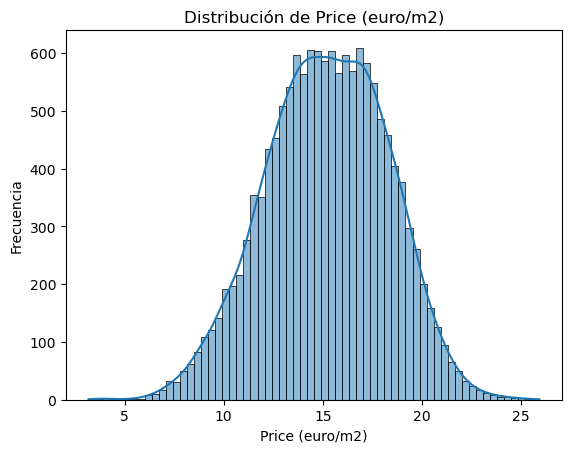

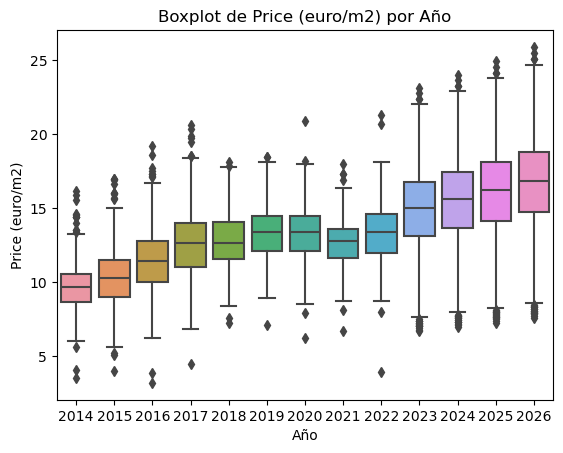

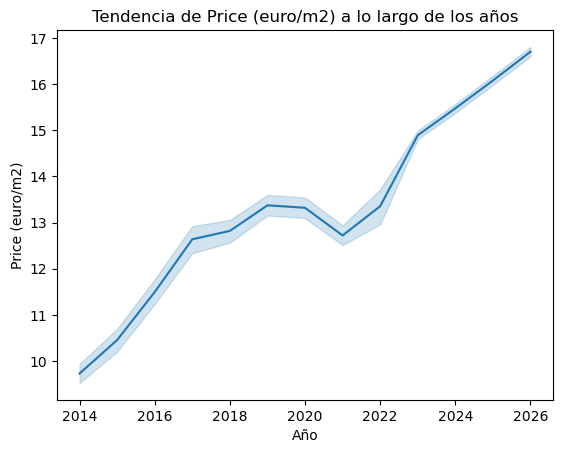

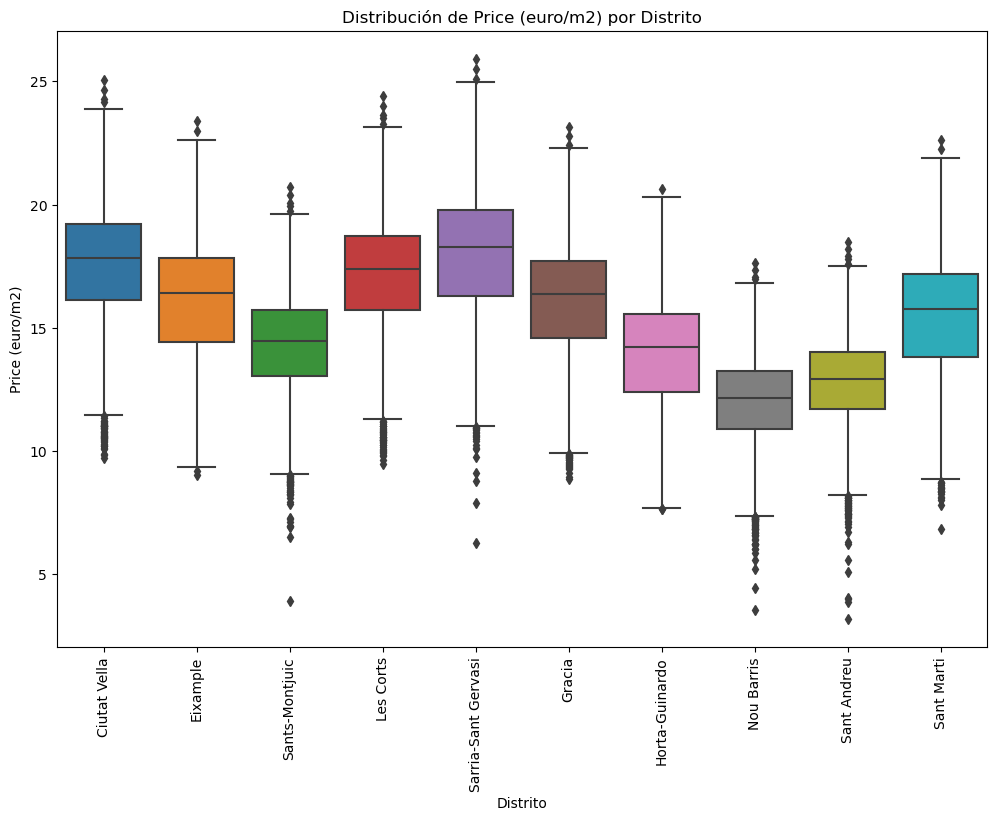

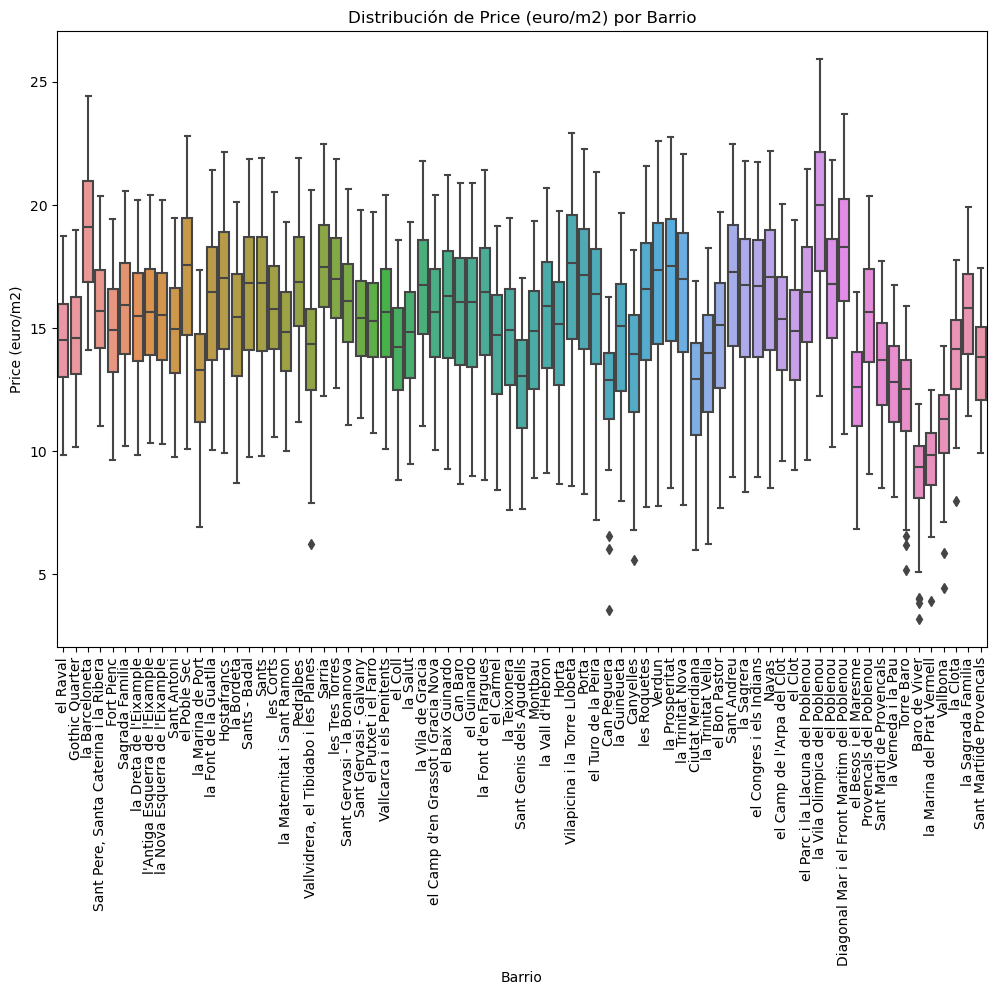

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset actualizado
data_actualizado = pd.read_csv('./prediccion_2023_2026_añadida.csv')

# Información general del dataset
print(data_actualizado.info())
print(data_actualizado.describe())

# Visualizaciones

# Distribución de Price (euro/m2)
sns.histplot(data_actualizado['Price (euro/m2)'], kde=True)
plt.title('Distribución de Price (euro/m2)')
plt.xlabel('Price (euro/m2)')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de Price (euro/m2) por Año
sns.boxplot(x='Year', y='Price (euro/m2)', data=data_actualizado)
plt.title('Boxplot de Price (euro/m2) por Año')
plt.xlabel('Año')
plt.ylabel('Price (euro/m2)')
plt.show()

# Tendencia de Price (euro/m2) a lo largo de los años
sns.lineplot(x='Year', y='Price (euro/m2)', data=data_actualizado)
plt.title('Tendencia de Price (euro/m2) a lo largo de los años')
plt.xlabel('Año')
plt.ylabel('Price (euro/m2)')
plt.show()

# Distribución de Precios por Distrito
plt.figure(figsize=(12, 8))
sns.boxplot(x='District', y='Price (euro/m2)', data=data_actualizado)
plt.title('Distribución de Price (euro/m2) por Distrito')
plt.xlabel('Distrito')
plt.ylabel('Price (euro/m2)')
plt.xticks(rotation=90)
plt.show()

# Distribución de Precios por Barrio
plt.figure(figsize=(12, 8))
sns.boxplot(x='Neighbourhood', y='Price (euro/m2)', data=data_actualizado)
plt.title('Distribución de Price (euro/m2) por Barrio')
plt.xlabel('Barrio')
plt.ylabel('Price (euro/m2)')
plt.xticks(rotation=90)
plt.show()
